Bound nuclear energy levels (MeV):

l=0  j=0.5  n=1  E=-45.075 MeV  deg=2
l=0  j=0.5  n=2  E=-32.972 MeV  deg=2
l=0  j=0.5  n=3  E=-17.028 MeV  deg=2
l=0  j=0.5  n=4  E=-1.753 MeV  deg=2
l=1  j=0.5  n=1  E=-46.578 MeV  deg=2
l=1  j=0.5  n=2  E=-30.801 MeV  deg=2
l=1  j=0.5  n=3  E=-12.771 MeV  deg=2
l=1  j=1.5  n=1  E=-36.060 MeV  deg=4
l=1  j=1.5  n=2  E=-16.444 MeV  deg=4
l=2  j=1.5  n=1  E=-32.638 MeV  deg=4
l=2  j=1.5  n=2  E=-12.938 MeV  deg=4
l=2  j=2.5  n=1  E=-24.541 MeV  deg=6
l=3  j=2.5  n=1  E=-36.561 MeV  deg=6
l=3  j=2.5  n=2  E=-13.189 MeV  deg=6
l=3  j=3.5  n=1  E=-10.518 MeV  deg=8


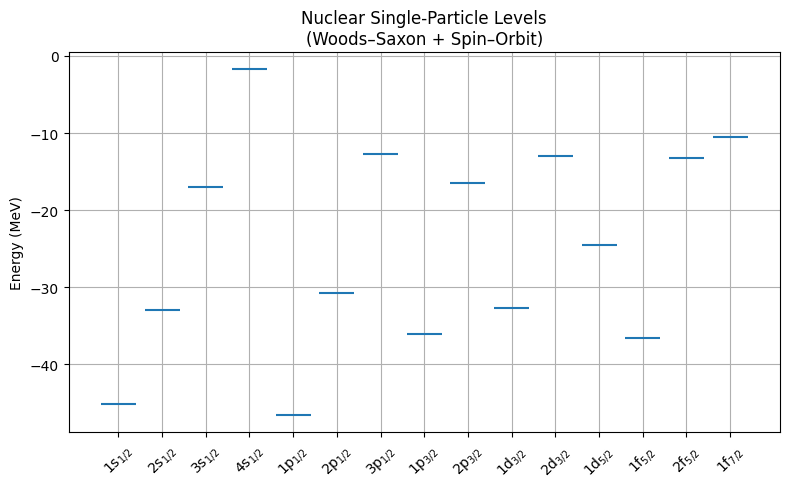

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
HBAR2_OVER_2M = 20.735  # MeV·fm²


# Woods–Saxon potential
def woods_saxon(r, V0=50, R=5.0, a=0.5):
    """Woods–Saxon central potential"""
    return -V0 / (1 + np.exp((r - R) / a))

def dwoods_saxon(r, V0=50, R=5.0, a=0.5):
    """Derivative of Woods–Saxon potential (for spin–orbit)"""
    exp_term = np.exp((r - R) / a)
    return (V0 / a) * exp_term / (1 + exp_term)**2


# Total potential (Woods–Saxon + spin–orbit)
def total_potential(r, l, j, V0=50, R=5.0, a=0.5, lam=6.5):
    """Compute total potential including spin-orbit interaction"""
    V_ws = woods_saxon(r, V0, R, a)
    dV = dwoods_saxon(r, V0, R, a)

    # Spin-orbit factor: j(j+1) - l(l+1) - s(s+1), with s=1/2
    so_factor = j*(j+1) - l*(l+1) - 0.75
    V_so = lam * dV * so_factor / r

    return V_ws + V_so


# Numerov method to solve radial Schrödinger equation
def numerov(E, V, r, l):
    """Solve radial wavefunction u(r) using Numerov algorithm"""
    h = r[1] - r[0]  # step size
    k2 = 2 * (E - V) / HBAR2_OVER_2M - l*(l+1)/r**2
    k2[0] = k2[1]  # avoid singularity at r=0

    u = np.zeros_like(r)
    u[0] = 0.0
    u[1] = 1e-6  # small initial value

    for i in range(1, len(r)-1):
        u[i+1] = (2*u[i]*(1 - 5*h*h*k2[i]/12) - u[i-1]*(1 + h*h*k2[i-1]/12)) / \
                 (1 + h*h*k2[i+1]/12)
    return u


# Find bound state energy levels
def find_bound_levels(l, j, E_min=-50, E_max=0, n_points=600):
    """Scan energies and detect bound states"""
    energies = []
    E_values = np.linspace(E_min, E_max, n_points)
    prev_sign = None

    for E in E_values:
        V = total_potential(r, l, j)
        u = numerov(E, V, r, l)
        sign = np.sign(u[-1])

        # Detect zero crossing at boundary
        if prev_sign is not None and sign != prev_sign:
            energies.append(E)
        prev_sign = sign

    return energies


# Radial grid
r = np.linspace(1e-5, 15, 2000)

# Compute energy levels for l=0,1,2,3 (s,p,d,f)
levels = {}
for l in range(4):
    for j in [l-0.5, l+0.5]:
        if j < 0:
            continue
        levels[(l, j)] = find_bound_levels(l, j)

# results
print("Bound nuclear energy levels (MeV):\n")
for (l, j), energies in levels.items():
    for n, E in enumerate(energies, 1):
        deg = int(2*j + 1)
        print(f"l={l}  j={j:.1f}  n={n}  E={E:.3f} MeV  deg={deg}")
# Plot energy level diagram
plt.figure(figsize=(8,5))
x_pos = 0
labels = []

for l in range(4):
    for j in [l-0.5, l+0.5]:
        if j < 0:
            continue
        energies = find_bound_levels(l, j)
        for n, E in enumerate(energies, 1):
            plt.hlines(E, x_pos-0.4, x_pos+0.4)
            labels.append(f"{n}{['s','p','d','f'][l]}$_{{{int(2*j)}/2}}$")
            x_pos += 1

plt.ylabel("Energy (MeV)")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.title("Nuclear Single-Particle Levels\n(Woods–Saxon + Spin–Orbit)")
plt.grid(True)
plt.tight_layout()
plt.show()
